In [3]:
import FCA, pickle, csv
import numpy as np
import pandas as pd
import networkx as nx
import statistics as s
from math import floor
from NNetwork import NNetwork as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings("ignore")

from sklearn.manifold import SpectralEmbedding

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
sampler = RandomUnderSampler()


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as rf

In [ ]:
def model_metrics(model, y_test, y_pred):
    conf_matrix = confusion_matrix(y_true = y_test, y_pred = y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                  display_labels=model.classes_)
    disp.plot()
    plt.show()
    
    print('Precision: %.3f' % precision_score(y_test, y_pred))
    print('Recall: %.3f' % recall_score(y_test, y_pred))
    print('F1: %.3f' % f1_score(y_test, y_pred))
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    
    pass
    return

In [4]:
# FCA_iter: total iteration for the FCA model, used for label
# baseline_iter: the iteration for baseline model, usually less than FCA_iter
# iter_include: number of iteration to include in the dataframe
# X: a list of graph structure (for each graph, length = k^2 if num_nodes=k)
# num_edges, num_nodes, min_degree, max_degree, diameter, quartile_1, quartile_2, quartile_3, states, y, baseline_width
def FCA_datagen(num_nodes, kappa, FCA_iter, baseline_iter, iter_include, file_name, X):
    # generate the toy dataset
    file = open(file_name, 'w+', newline='')

    header = ["num_edges", "num_nodes", "min_degree", "max_degree", "diameter", "quartile_1",
              "quartile_2", "quartile_3", "y", "baseline_width"]
    for i in range(baseline_iter):
        for j in range(num_nodes):
            header.append("s" + str(i + 1) + "_" + str(j + 1))

    with file:
        write = csv.writer(file)

        write.writerow(header)
        for i in range(X.shape[1]): #X.shape = (400, 3000)
            G=nx.from_pandas_adjacency(pd.DataFrame(X[:,i].reshape(20, -1)))
            G=nx.Graph(G)
            
            
            col = np.random.randint(0,kappa,size=num_nodes)

            num_edges = G.number_of_edges()
            min_degree = min(list(G.degree), key=lambda x: x[1])[1]
            max_degree = max(list(G.degree), key=lambda x: x[1])[1]
            diameter = nx.diameter(G)
            quartile_1 = s.quantiles(col, n=4)[0]
            quartile_2 = s.quantiles(col, n=4)[1]
            quartile_3 = s.quantiles(col, n=4)[2]

            sample = [num_edges, num_nodes, min_degree, max_degree, diameter,
                      quartile_1, quartile_2, quartile_3]
            states, label = FCA.FCA(G, col, kappa, FCA_iter)

            width = FCA.width_compute(states[FCA_iter - 1], kappa)
            y = False
            if (width < floor(kappa / 2)):  # half circle concentration
                y = True
            sample.append(y)

            baseline_width = FCA.width_compute(states[baseline_iter - 1], kappa)
            baseline = False
            if (baseline_width < floor(kappa / 2)):  # half circle concentration
                baseline = True
            sample.append(baseline)

            for j in range(iter_include):
                sample = sample + list(states[j])

            write.writerow(sample)
    #return graph_list

In [5]:
### from network_sampling_ex
def coding(X, W, H0, 
          r=None, 
          a1=0, #L1 regularizer
          a2=0, #L2 regularizer
          sub_iter=[5], 
          stopping_grad_ratio=0.0001, 
          nonnegativity=True,
          subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + a1*|H| + a2*|H|_{F}^{2} ) within radius r from H0
    Use row-wise projected gradient descent
    """
    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation
    grad = W.T @ (W @ H0 - X)
    while (i < np.random.choice(sub_iter)):
        step_size = (1 / (((i + 1) ** (1)) * (np.trace(A) + 1)))
        H1 -= step_size * grad 
        if nonnegativity:
            H1 = np.maximum(H1, 0)  # nonnegativity constraint
        i = i + 1
    return H1


def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        a12 = 0, # L2 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):
    
        '''
        Given data matrix X, use alternating least squares to find factors W,H so that 
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1} + a12 * |W|_{F}^{2}
        is minimized (at least locally)
        '''
        
        d, n = X.shape
        r = n_components
        
        #normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        #print('!!! avg entry of X', normalization)
        #X = X/normalization

        # Initialize factors 
        W = np.random.rand(d,r)
        H = np.random.rand(r,n) 
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            #H = coding_within_radius(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            #W = coding_within_radius(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            H = coding(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            W /= np.linalg.norm(W)
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H
    
def display_dictionary(W, save_name=None, score=None, grid_shape=None, figsize=[10,10]):
    k = int(np.sqrt(W.shape[0]))
    rows = int(np.sqrt(W.shape[1]))
    cols = int(np.sqrt(W.shape[1]))
    if grid_shape is not None:
        rows = grid_shape[0]
        cols = grid_shape[1]
    
    figsize0=figsize
    if (score is None) and (grid_shape is not None):
        figsize0=(cols, rows)
    if (score is not None) and (grid_shape is not None):
        figsize0=(cols, rows+0.2)
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize0,
                            subplot_kw={'xticks': [], 'yticks': []})
        
        
    for ax, i in zip(axs.flat, range(100)):
        if score is not None:
            idx = np.argsort(score)
            idx = np.flip(idx)    
            
            ax.imshow(W.T[idx[i]].reshape(k, k), cmap="viridis", interpolation='nearest')
            ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
            ax.xaxis.set_label_coords(0.5, -0.05)
        else: 
            ax.imshow(W.T[i].reshape(k, k), cmap="viridis", interpolation='nearest')
            if score is not None:
                ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.05)
       
    plt.tight_layout()
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    if save_name is not None:
        plt.savefig( save_name, bbox_inches='tight')
    plt.show()

In [8]:
sampling_alg = 'pivot'

ntwk = 'Caltech36' # COVID_PPI, Wisconsin87, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'Subgraph_sampling/test1/'
k=20

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 769
num edges in G 33312


In [9]:
X, embs = G.get_patches(k=k, sample_size=10000, skip_folded_hom=True)
file = open('toy.pkl', 'wb')
pickle.dump(X, file)
file.close()
X.shape

num of subgraphs induced on k-paths: 10000


(400, 10000)

In [10]:
num_nodes = 20
kappa = 10
FCA_iter = 200
baseline_iter = 50
iter_include = 5
file_name = "toy.csv"
FCA_datagen(num_nodes, kappa, FCA_iter, baseline_iter, iter_include, file_name, X)

In [18]:
df = pd.read_csv("toy.csv")
df

,num_edges,num_nodes,min_degree,max_degree,diameter,quartile_1,quartile_2,quartile_3,y,baseline_width,...,s5_11,s5_12,s5_13,s5_14,s5_15,s5_16,s5_17,s5_18,s5_19,s5_20
0,47,20,2,8,5,2.00,4.0,5.00,True,True,...,4,6,7,8,6,7,6,5,6,5
1,55,20,1,12,4,3.25,5.5,6.00,True,False,...,5,9,0,6,4,5,8,8,9,0
2,55,20,2,9,5,2.00,5.5,8.00,True,True,...,3,6,0,2,0,2,1,8,4,4
3,56,20,2,9,3,3.00,6.0,7.00,True,True,...,7,7,7,9,8,7,7,7,9,8
4,53,20,2,14,3,4.00,5.5,7.75,True,False,...,7,6,5,7,8,0,7,7,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,49,20,2,8,4,2.00,3.5,5.75,True,False,...,6,7,7,5,5,7,6,5,6,8
9996,42,20,2,7,5,1.00,3.5,5.75,True,True,...,5,8,4,1,7,6,8,8,7,7
9997,45,20,2,8,4,1.50,5.0,6.75,True,False,...,3,4,7,9,2,8,8,4,8,4
9998,49,20,2,9,4,4.25,6.0,8.00,True,False,...,2,9,5,3,0,9,8,6,6,8


In [19]:
df.y.value_counts()

True     9260
False     740
Name: y, dtype: int64

In [20]:
df.baseline_width.value_counts()

False    5280
True     4720
Name: baseline_width, dtype: int64

In [22]:
df.shape

(10000, 110)

In [26]:
X_adj = X.T
X_adj.shape

(10000, 400)

### The dimension of the projected subspace = 2

In [27]:
embedding = SpectralEmbedding(n_components=2)
X_transformed = embedding.fit_transform(X_adj)
X_transformed.shape

(10000, 2)

In [29]:
y = df.y.astype('int')


In [31]:
y.shape

(10000,)

In [34]:
X_resampled, y_resampled = sampler.fit_resample(X_transformed, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)

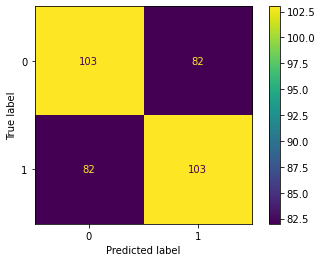

Precision: 0.557
Recall: 0.557
F1: 0.557
Accuracy: 0.557


In [38]:


clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

### The dimension of the projected subspace = 10

In [39]:
embedding = SpectralEmbedding(n_components=10)
X_transformed2 = embedding.fit_transform(X_adj)
X_transformed2.shape

(10000, 10)

In [40]:
X_resampled, y_resampled = sampler.fit_resample(X_transformed2, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)

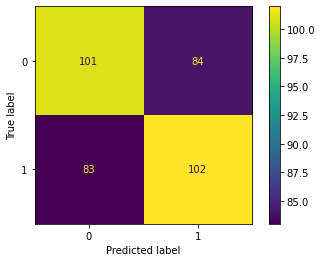

Precision: 0.548
Recall: 0.551
F1: 0.550
Accuracy: 0.549


In [41]:
clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

### The dimension of the projected subspace = 100

In [42]:
embedding = SpectralEmbedding(n_components=100)
X_transformed3 = embedding.fit_transform(X_adj)
X_transformed3.shape

(10000, 100)

In [47]:
X_resampled, y_resampled = sampler.fit_resample(X_transformed3, y)
    
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)

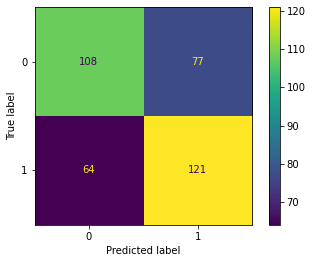

Precision: 0.611
Recall: 0.654
F1: 0.632
Accuracy: 0.619


In [48]:
clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

In [50]:
X.shape

(400, 10000)

### Check node2vec and graph2vec

In [62]:
X[:,i].reshape(20, -1) #adjacency matrix of the first sample
int(np.sqrt(X.shape[0]))

20

In [63]:
graph_list = []
for i in range(10000):
    G=nx.from_pandas_adjacency(pd.DataFrame(X[:,i].reshape(20, -1)))
    G=nx.Graph(G)
    graph_list.append(G)

In [64]:
len(graph_list)

10000

In [65]:
from karateclub import Node2Vec

In [66]:
def n2v_embedding(graph_list):

    df_n2v = pd.DataFrame()

    for graph in graph_list:        
        n2v = Node2Vec(dimensions = 1)
        n2v.fit(graph)
        embed = n2v.get_embedding()
        df_embed = pd.DataFrame(embed.T)
        df_n2v = pd.concat([df_n2v, df_embed], ignore_index=True, axis=0)
        
    return df_n2v


In [ ]:
df_n2v = n2v_embedding(graph_list)

In [ ]:
df_n2v.shape

In [ ]:
X_resampled, y_resampled = sampler.fit_resample(df_n2v, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)


clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)